<a href="https://colab.research.google.com/github/28rodrigo/DeepLearningCNNs/blob/main/Trabalho_Pratico_ClassificacaoPaisagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classificação de Imagens de Paisagens**

**Deeplearning Aplicado - UTAD**


Docentes: António Cunha e Alexandre Neto


Trabalho Realizado por: 
*    João Costa - al59259
*    Rodrigo Pereira - al68798

# Introdução

Com este trabalho pretende-se desenvolver uma CNN (Convolutional Neural Network) capaz de classificar imagens de paisagens em 6 categorias (Edificios, Floresta, Glaciar, Montanha, Mar e Rua).

Pretende-se também explorar diferentes métodos de optimização dos modelos, nomeadamente:
*    Redimensionar as camadas do modelo
*    Dropout
*    Regularização L1 e L2
*    Diferentes Otimizadores
*    Data Augmentation
*    Transfer Learning

## Introdução do Dataset

Foi utilizado o dataset ["Intel Image Classification"](https://www.kaggle.com/puneet6060/intel-image-classification), composto por cerca de 25k imagens de Cenários Naturais, de tanho 150x150, distribuídas por 6 categorias (Edificios, Floresta, Glaciar, Montanha, Mar e Rua).

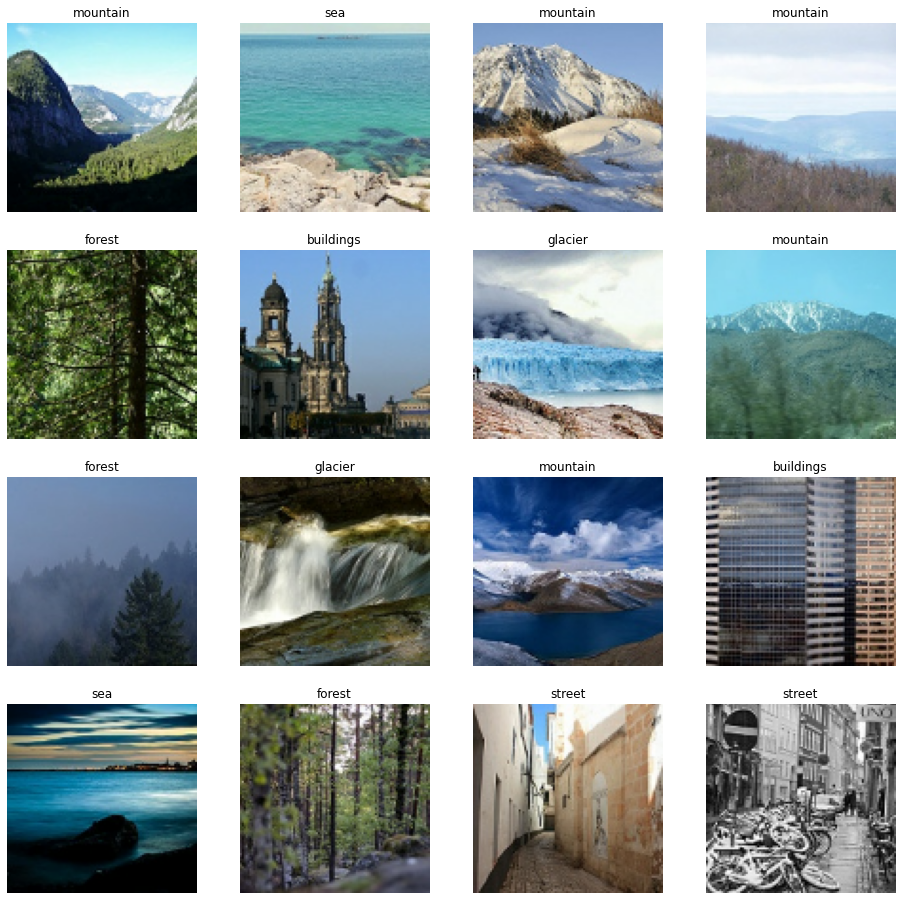

In [ ]:
plt.figure(figsize=(16, 16))
class_names = train_dataset.class_names
cls = np.array(class_names)
for images, labels in train_dataset.take(1):
    lbls = np.array(labels).astype(int)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.title(cls[np.argmax(lbls, axis=1)][i])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# 1. Setup

## 1.1 Import libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
import numpy as np
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tensorflow.keras.utils import image_dataset_from_directory
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from random import randint
import cv2
import glob as gb
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## 1.2 Definir caminhos para os dados

In [ ]:
trainpath ='/content/drive/MyDrive/Deeplearning/TP2_dataset/seg_train/seg_train/'
testpath ='/content/drive/MyDrive/Deeplearning/TP2_dataset/seg_test/seg_test/'

# 2. Tratamento de dados

## 2.1 Importar dados e definir datasets 

### Treino

In [ ]:
train_dataset = image_dataset_from_directory(
    trainpath,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(100, 100),
    batch_size=32)

Found 13653 files belonging to 6 classes.
Using 10923 files for training.


In [ ]:
train_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Validação

In [ ]:
validation_dataset = image_dataset_from_directory(
  trainpath,
  validation_split=0.2,
  label_mode="categorical",
  subset="validation",
  seed=123,
  image_size=(100, 100),    
  batch_size=32)

Found 13653 files belonging to 6 classes.
Using 2730 files for validation.


### Teste

In [ ]:
test_dataset = image_dataset_from_directory(
    testpath,
    label_mode="categorical",
    seed=123,
    image_size=(100, 100),
    batch_size=32)

Found 3000 files belonging to 6 classes.


## 2.2 Melhorar performance

Usámos o autotune para melhorar a performace no tratamento dos dados

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

validation_dataset= validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

test_dataset= test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# 3. Análise dos Datasets

In [ ]:
code = {'street':'000001' ,'sea':'000010','mountain':'000100','glacier':'001000','forest':'010000','buildings':'100000'}
def getlabel(n) : 
    for x , y in code.items():
      for k in range(len(n)):
        if n[k] == y : 
          n[k]=x 
    return n

In [ ]:
def getdistribution(dataset,labelx,labely,title):
  dist_dic={"000001":0,"000010":0,"000100":0,"001000":0,"010000":0,"100000":0}
  i=0
  k=0
  for element in tqdm(dataset.as_numpy_iterator()):
    for k in range(len(element[1])):
      dist_dic["".join([str(i) for i in element[1][k].astype(int)])]=dist_dic["".join([str(i) for i in element[1][k].astype(int)])] + 1
  k=0
  i=i+1
  print(dist_dic)
  keys = list(dist_dic.keys())
  keys=getlabel(keys)
  values = list(dist_dic.values())
  plt.bar(keys, values, color ='blue')
  plt.xlabel(labelx)
  plt.ylabel(labely)
  plt.title(title)
  plt.show()


## 3.1 Distribuição do dataset de treino

In [ ]:
getdistribution(train_dataset,"Label da amostra","nº de amostras","Gráfico 1 - Distribuição das amostras de treino")

0it [00:00, ?it/s]

Como podemos observar, as imagens do dataset de treino têm uma distribuição aceitável pelas 6 classes, não sendo necessário ajustar o número de imagens.

## 3.2 Distribuição do dataset de validação

{'000001': 485, '000010': 447, '000100': 502, '001000': 388, '010000': 472, '100000': 436}


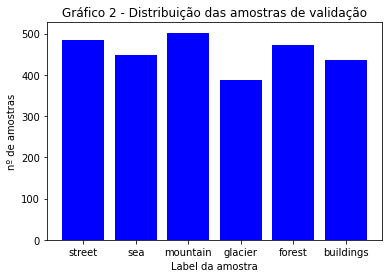

In [ ]:
getdistribution(validation_dataset,"Label da amostra","nº de amostras","Gráfico 2 - Distribuição das amostras de validação")

Como no gráfico anterior, o dataset de validação tem também uma boa distribuição das imagens pelas classes.

# 4. Implementar modelo

## 4.1 Construir modelo

In [ ]:
model = keras.models.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(100,100, 3)),
        keras.layers.Conv2D(16,kernel_size=3,activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(256,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),      
        keras.layers.Dense(50,activation='relu') ,                   
        keras.layers.Dense(6,activation='softmax') ,    
        ])

Aqui é definida a estrutura do nosso modelo. Foram tomadas as seguintes decisões:


*   Camada "Rescaling" para redimensionar todas as imagens (algumas imagens tinham tamanhos diferentes)
*   Camadas convolucionais Conv2D, para extração de features. Foram adicionadas 5 camadas pois é um número comum nos exemplos vistos.
*   Função de ativação "Relu", pois esta é também a mais frequente nos exemplos vistos.
*   Camadas de MaxPooling após cada camada convolucional.
*   Camada Flatten, após a parte convolucional da rede, para servir de input à NN.
*   Camada Dense para classificação.
*   Camada Dense final, com função de ativação "softmax", pois é um problema de classificação multiclasse.



## 4.2 Compilar modelo

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

*    Função loss: categorical_crossentropy (problema de multiclasse).
*    Otimizador: RMSProp. Um otimizador bastante comum.
*    Metricas: Accuracy. Também a métrica mais comum para estes problemas.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

## 4.3 Treinar modelo

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset)

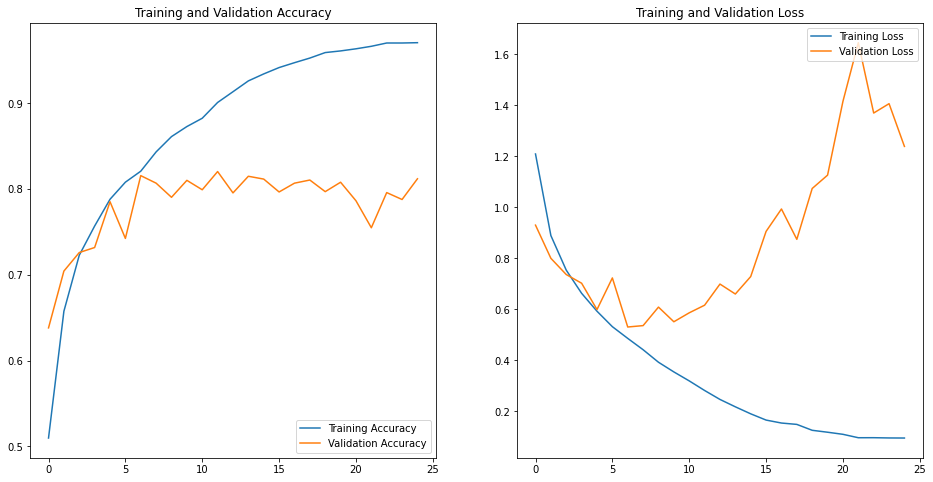

In [ ]:
num_epochs = 25

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4.4 Avaliar modelo

In [ ]:
model.evaluate(test_dataset)

94/94 [==============================] - 380s 10ms/step - loss: 0.9537 - accuracy: 0.7870


[0.9537186026573181, 0.7870000004768372]

# 5. Variações / Melhorias do modelo

O modelo anterior vai ser usado como base de testes usando diferentes técnicas

## 5.1 Dimensões/camadas do modelo

In [ ]:
model = keras.models.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(100,100, 3)),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),      
        keras.layers.Dense(32,activation='relu') ,                   
        keras.layers.Dense(6,activation='softmax') ,    
        ])

Depois de feitos vários testes com diferentes configurações, foi decidido:

*    Remover uma camada Conv2D
*    Reduzir o tamanho da camada Dense

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset)

Epoch 1/25
342/342 [==============================] - 8s 22ms/step - loss: 1.2004 - accuracy: 0.5146 - val_loss: 0.9048 - val_accuracy: 0.6648
Epoch 2/25
342/342 [==============================] - 7s 21ms/step - loss: 0.8954 - accuracy: 0.6597 - val_loss: 0.7379 - val_accuracy: 0.7187
Epoch 3/25
342/342 [==============================] - 7s 21ms/step - loss: 0.7553 - accuracy: 0.7244 - val_loss: 0.8847 - val_accuracy: 0.6637
Epoch 4/25
342/342 [==============================] - 7s 21ms/step - loss: 0.6732 - accuracy: 0.7521 - val_loss: 0.6003 - val_accuracy: 0.7714
Epoch 5/25
342/342 [==============================] - 7s 21ms/step - loss: 0.6034 - accuracy: 0.7833 - val_loss: 0.5748 - val_accuracy: 0.7897
Epoch 6/25
342/342 [==============================] - 7s 21ms/step - loss: 0.5374 - accuracy: 0.8082 - val_loss: 0.5575 - val_accuracy: 0.7989
Epoch 7/25
342/342 [==============================] - 7s 21ms/step - loss: 0.4881 - accuracy: 0.8277 - val_loss: 0.5576 - val_accuracy: 0.7956

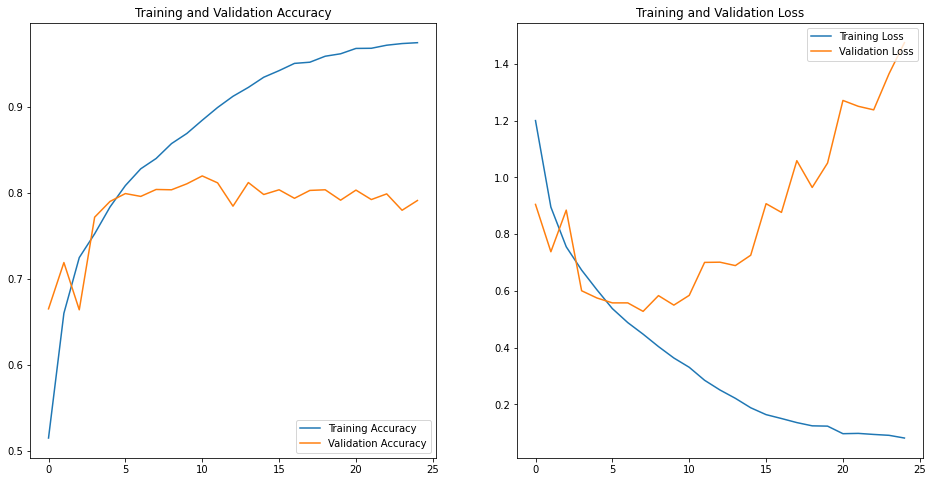

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Este parâmetro não parece ter um grande efeito na nossa rede.

## 5.2 Dropout

Depois de pesquisa de exemplos, e após vários testes, foi decidido:
*    Adicionar uma camada Dropout imediatamente após a parte convolucional da rede.
*    Dar um valor de 0.5 ao dropout.

In [ ]:
model = keras.models.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(100,100, 3)),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),      
        keras.layers.Dense(32,activation='relu') ,                   
        keras.layers.Dense(6,activation='softmax') ,    
        ])

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset)

Epoch 1/25
342/342 [==============================] - 8s 22ms/step - loss: 1.2214 - accuracy: 0.5022 - val_loss: 1.0419 - val_accuracy: 0.5707
Epoch 2/25
342/342 [==============================] - 7s 21ms/step - loss: 0.9148 - accuracy: 0.6502 - val_loss: 0.7595 - val_accuracy: 0.7106
Epoch 3/25
342/342 [==============================] - 7s 21ms/step - loss: 0.7829 - accuracy: 0.7035 - val_loss: 0.6403 - val_accuracy: 0.7696
Epoch 4/25
342/342 [==============================] - 7s 21ms/step - loss: 0.7028 - accuracy: 0.7446 - val_loss: 0.6828 - val_accuracy: 0.7429
Epoch 5/25
342/342 [==============================] - 7s 21ms/step - loss: 0.6304 - accuracy: 0.7743 - val_loss: 0.6402 - val_accuracy: 0.7623
Epoch 6/25
342/342 [==============================] - 7s 21ms/step - loss: 0.5713 - accuracy: 0.7959 - val_loss: 0.5904 - val_accuracy: 0.7861
Epoch 7/25
342/342 [==============================] - 7s 21ms/step - loss: 0.5404 - accuracy: 0.8063 - val_loss: 0.5831 - val_accuracy: 0.7842

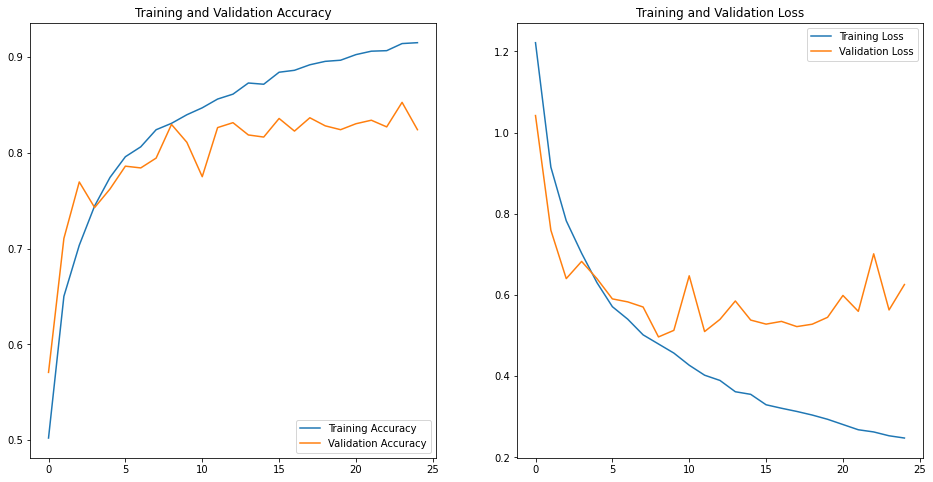

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

É possível verificar uma ligeira melhoria com a adição de Dropout.

## 5.3 Regularização L1 e L2 e Otimizador

Após pesquisa de exemplos, foi decidido adicionar regularização L1 e L2 à camada Dense da parte de classificação.

Em relação ao otimizador, decidimos testar o "Adam", que é o otimizador "RMSProp" com a adição de "Momentum", que tem em conta os gradientes anteriors, para uma melhor atualização dos pesos.

In [ ]:
model = keras.models.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(100,100, 3)),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),      
        keras.layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)) ,                   
        keras.layers.Dense(6,activation='softmax') ,    
        ])

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset)

Epoch 1/25
342/342 [==============================] - 9s 22ms/step - loss: 1.2295 - accuracy: 0.4972 - val_loss: 0.9374 - val_accuracy: 0.6319
Epoch 2/25
342/342 [==============================] - 7s 21ms/step - loss: 0.9317 - accuracy: 0.6471 - val_loss: 0.8621 - val_accuracy: 0.6612
Epoch 3/25
342/342 [==============================] - 7s 21ms/step - loss: 0.8173 - accuracy: 0.7022 - val_loss: 0.7083 - val_accuracy: 0.7399
Epoch 4/25
342/342 [==============================] - 7s 21ms/step - loss: 0.7312 - accuracy: 0.7394 - val_loss: 0.6567 - val_accuracy: 0.7637
Epoch 5/25
342/342 [==============================] - 7s 21ms/step - loss: 0.6726 - accuracy: 0.7661 - val_loss: 0.6891 - val_accuracy: 0.7586
Epoch 6/25
342/342 [==============================] - 7s 21ms/step - loss: 0.6327 - accuracy: 0.7790 - val_loss: 0.5940 - val_accuracy: 0.7949
Epoch 7/25
342/342 [==============================] - 7s 21ms/step - loss: 0.5942 - accuracy: 0.7979 - val_loss: 0.6234 - val_accuracy: 0.7813

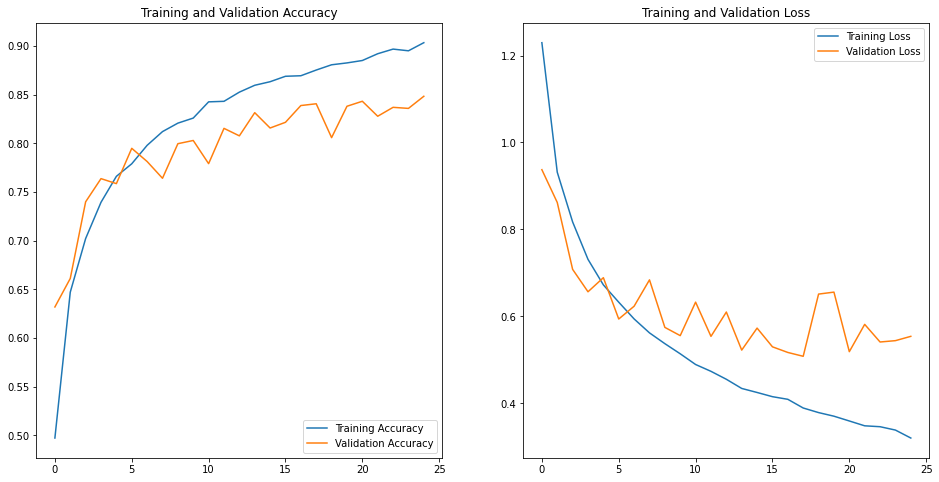

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

A regularização L1 e L2 e a mudança do otimizador apresentam também uma melhoria na acurácia do modelo. 

## 5.4 Avaliação após otimizações

In [ ]:
model.evaluate(test_dataset)

94/94 [==============================] - 1s 11ms/step - loss: 0.5827 - accuracy: 0.8313


[0.5826541781425476, 0.831333339214325]

0.78 -> 0.83

# 6. Data Augmentation

Vamos aplicar Data Augmentation, usando o melhor modelo prévio.

São aplicadas Rotações e Zooms aleatórios às imagens.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## 6.1 Exemplo de Data Augmentation de uma imagem 

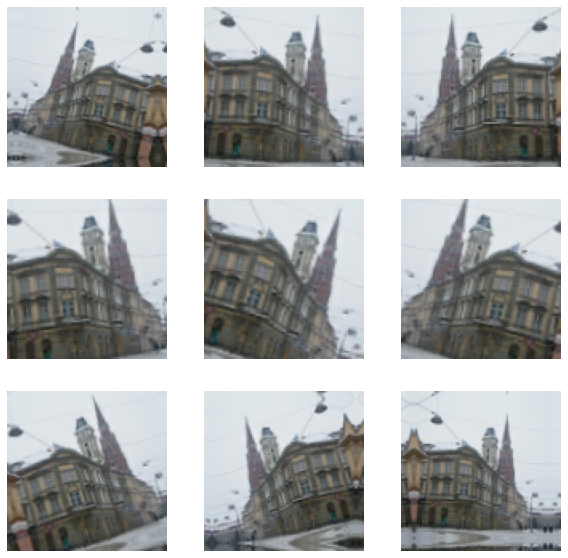

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 6.2 Alteração do modelo

Adicionar a camada de Data Augmentation ao modelo

In [ ]:
model = keras.models.Sequential([
        data_augmentation,
        keras.layers.Rescaling(1./255, input_shape=(100,100, 3)),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128,kernel_size=3,activation='relu'),    
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),      
        keras.layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)) ,                   
        keras.layers.Dense(6,activation='softmax') ,    
        ])

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
342/342 [==============================] - 10s 24ms/step - loss: 1.2869 - accuracy: 0.4731 - val_loss: 1.0956 - val_accuracy: 0.5769
Epoch 2/100
342/342 [==============================] - 8s 23ms/step - loss: 1.0119 - accuracy: 0.6066 - val_loss: 0.8798 - val_accuracy: 0.6505
Epoch 3/100
342/342 [==============================] - 8s 23ms/step - loss: 0.9099 - accuracy: 0.6627 - val_loss: 0.8161 - val_accuracy: 0.6864
Epoch 4/100
342/342 [==============================] - 8s 23ms/step - loss: 0.8409 - accuracy: 0.6885 - val_loss: 0.7167 - val_accuracy: 0.7256
Epoch 5/100
342/342 [==============================] - 8s 23ms/step - loss: 0.7845 - accuracy: 0.7142 - val_loss: 0.8338 - val_accuracy: 0.6985
Epoch 6/100
342/342 [==============================] - 8s 23ms/step - loss: 0.7461 - accuracy: 0.7308 - val_loss: 0.7668 - val_accuracy: 0.6967
Epoch 7/100
342/342 [==============================] - 8s 23ms/step - loss: 0.7140 - accuracy: 0.7459 - val_loss: 0.7345 - val_accuracy

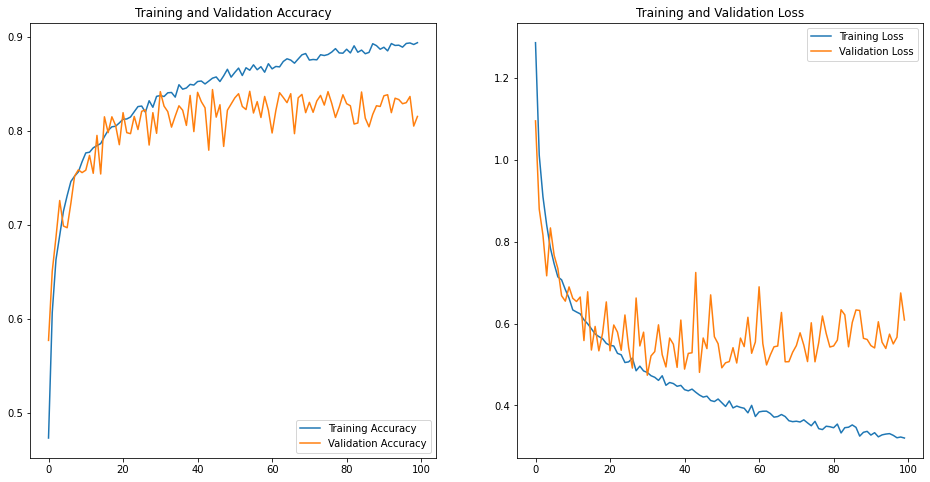

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_dataset)

94/94 [==============================] - 1s 9ms/step - loss: 0.6105 - accuracy: 0.8250


[0.6105490922927856, 0.824999988079071]

Apesar de ser uma estratégia muito comum, o nosso modelo não parece melhorar significativamente com a adição de Data Augmentation

# 7. Transfer Learning

## 7.1 Usando a rede Vgg16

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(100, 100, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### 7.1.1 Extração de Features da rede pré-treinada

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(10923, 3, 3, 512)

### 7.1.2 Adição da rede de classificação

In [ ]:
inputs = keras.Input(shape=(3, 3, 512)) #alterar shape
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/50
342/342 [==============================] - 2s 6ms/step - loss: 0.5211 - accuracy: 0.8495 - val_loss: 0.3270 - val_accuracy: 0.9007
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 0.3195 - accuracy: 0.9011 - val_loss: 0.2954 - val_accuracy: 0.9000
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 0.2836 - accuracy: 0.9075 - val_loss: 0.2743 - val_accuracy: 0.9077
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: 0.2635 - accuracy: 0.9102 - val_loss: 0.2768 - val_accuracy: 0.8989
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: 0.2510 - accuracy: 0.9142 - val_loss: 0.2694 - val_accuracy: 0.9073
Epoch 6/50
342/342 [==============================] - 2s 5ms/step - loss: 0.2365 - accuracy: 0.9224 - val_loss: 0.2786 - val_accuracy: 0.9026
Epoch 7/50
342/342 [==============================] - 2s 5ms/step - loss: 0.2343 - accuracy: 0.9197 - val_loss: 0.2743 - val_accuracy: 0.9037
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/TP2/model_with_vgg')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TP2/model_with_vgg/assets


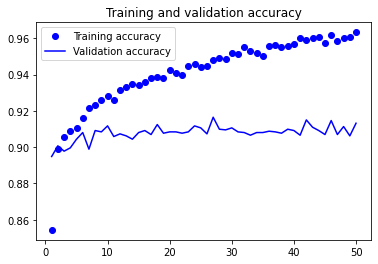

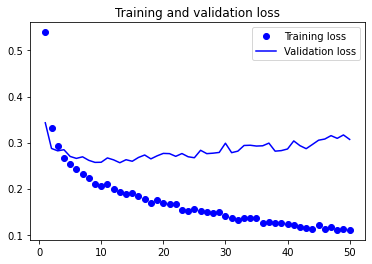

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Usando uma rede pré treinada, vemos uma grande melhoria no nosso modelo.

De uma accuracy de ~80% -> ~90%

## 7.2 Usando data augmentation

Instanciar e congelar a base convolucional da VGG16

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


Diferença entre parâmetros treináveis, antes e após o congelamento

In [ ]:
conv_base.trainable = True
print("Numero de parametros treináveis antes de congelar:", len(conv_base.trainable_weights))

Numero de parametros treináveis antes de congelar: 26


In [ ]:
conv_base.trainable = False
print("Numero de parametros treináveis depois de congelar:", len(conv_base.trainable_weights))

Numero de parametros treináveis depois de congelar: 0


### 7.2.1 Adicionar Data Augmentation e Classificador


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callback - em vez de fazer early stop ir buscar os melhores valores.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

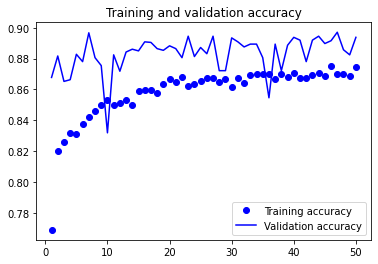

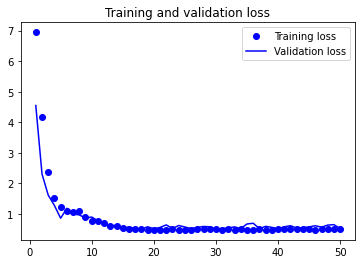

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 7.2.2 Avaliar o modelo

In [ ]:
test_loss, test_acc =model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

94/94 [==============================] - 7s 74ms/step - loss: 0.5286 - accuracy: 0.8873
Test accuracy: 0.887


Como vimos acima, o data augmentation não parece melhorar o nosso modelo

## 7.3 Usando a rede MobileNetV2

In [ ]:
conv_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(100, 100, 3))
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_13[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][

### 7.3.1 Extração de Features da rede pré-treinada

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


In [ ]:
train_features.shape

(10923, 4, 4, 1280)

### 7.3.2 Adição da rede de classificação

In [ ]:
inputs = keras.Input(shape=(4, 4, 1280)) #alterar shape
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels))

Epoch 1/50
342/342 [==============================] - 3s 6ms/step - loss: 1.3287 - accuracy: 0.4882 - val_loss: 0.9715 - val_accuracy: 0.6685
Epoch 2/50
342/342 [==============================] - 2s 6ms/step - loss: 0.8801 - accuracy: 0.7049 - val_loss: 0.5857 - val_accuracy: 0.8495
Epoch 3/50
342/342 [==============================] - 2s 6ms/step - loss: 0.6380 - accuracy: 0.7809 - val_loss: 0.3664 - val_accuracy: 0.8821
Epoch 4/50
342/342 [==============================] - 2s 6ms/step - loss: 0.4890 - accuracy: 0.8109 - val_loss: 0.3827 - val_accuracy: 0.8864
Epoch 5/50
342/342 [==============================] - 2s 6ms/step - loss: 0.4336 - accuracy: 0.8292 - val_loss: 0.3412 - val_accuracy: 0.8879
Epoch 6/50
342/342 [==============================] - 2s 6ms/step - loss: 0.3874 - accuracy: 0.8418 - val_loss: 0.3312 - val_accuracy: 0.8945
Epoch 7/50
342/342 [==============================] - 2s 6ms/step - loss: 0.3676 - accuracy: 0.8520 - val_loss: 0.3061 - val_accuracy: 0.9033
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_with_mobilenetv2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model_with_mobilenetv2/assets


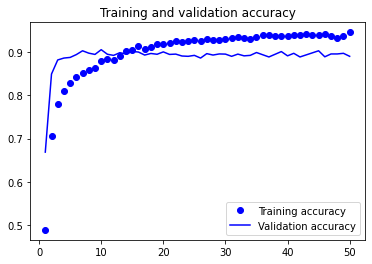

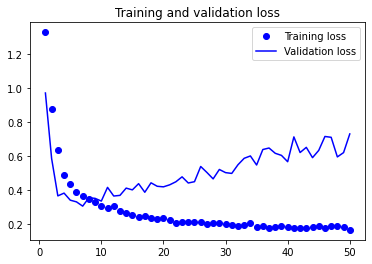

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Usando uma rede pré treinada, vemos uma grande melhoria no nosso modelo.

De uma accuracy de ~80% -> ~90%

## 7.4 Usando data augmentation - MobileNetV2

Instanciar e congelar a base convolucional da MobileNetv2

In [ ]:
conv_base  = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Diferença entre parâmetros treináveis, antes e após o congelamento

In [ ]:
conv_base.trainable = True
print("Numero de parametros treináveis antes de congelar:", len(conv_base.trainable_weights))

Numero de parametros treináveis antes de congelar: 156


In [ ]:
conv_base.trainable = False
print("Numero de parametros treináveis depois de congelar:", len(conv_base.trainable_weights))

Numero de parametros treináveis depois de congelar: 0


### 7.4.1 Adicionar Data Augmentation e Classificador


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset)

Epoch 1/25
342/342 [==============================] - 45s 119ms/step - loss: 0.9561 - accuracy: 0.6646 - val_loss: 0.4477 - val_accuracy: 0.8476
Epoch 2/25
342/342 [==============================] - 34s 99ms/step - loss: 0.7034 - accuracy: 0.7388 - val_loss: 0.4181 - val_accuracy: 0.8681
Epoch 3/25
342/342 [==============================] - 36s 103ms/step - loss: 0.6412 - accuracy: 0.7706 - val_loss: 0.3870 - val_accuracy: 0.8744
Epoch 4/25
342/342 [==============================] - 35s 101ms/step - loss: 0.6161 - accuracy: 0.7779 - val_loss: 0.4225 - val_accuracy: 0.8557
Epoch 5/25
342/342 [==============================] - 35s 100ms/step - loss: 0.5797 - accuracy: 0.7882 - val_loss: 0.3977 - val_accuracy: 0.8773
Epoch 6/25
342/342 [==============================] - 34s 99ms/step - loss: 0.5527 - accuracy: 0.7980 - val_loss: 0.4466 - val_accuracy: 0.8718
Epoch 7/25
342/342 [==============================] - 35s 101ms/step - loss: 0.5469 - accuracy: 0.8025 - val_loss: 0.4413 - val_accu

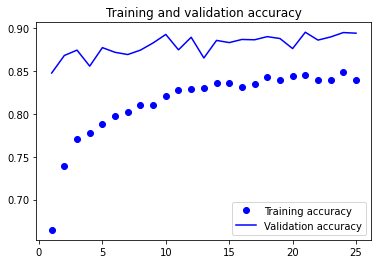

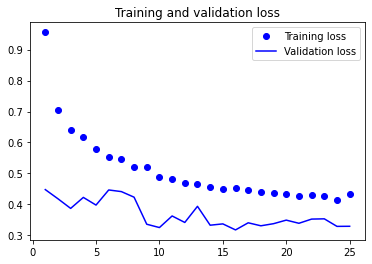

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 7.4.2 Avaliar o modelo

In [ ]:
test_loss, test_acc =model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

94/94 [==============================] - 8s 80ms/step - loss: 0.3360 - accuracy: 0.8787
Test accuracy: 0.879


Como vimos acima, o data augmentation não parece melhorar o nosso modelo

## 7.5 Comparar resultados

Podemos concluir que não existe diferenças consideráveis usando duas redes pré-treinadas diferentes.

# 8. Predictions

## 8.1 Predictions usando o vgg16

### 8.1.1 Carregar Prediction dataset

In [ ]:
files = gb.glob(pathname= str('/content/drive/MyDrive/Colab Notebooks/TP2/TP2_dataset/seg_pred/' +'seg_pred/*.jpg'))
print(f'For Prediction data , found {len(files)}')


For Prediction data , found 7325


In [ ]:
X_pred = []
for file in files: 
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = cv2.resize(image , (100,100))
    X_pred.append(list(image_array))       

### 8.1.2 Amostra do dataset de predictions

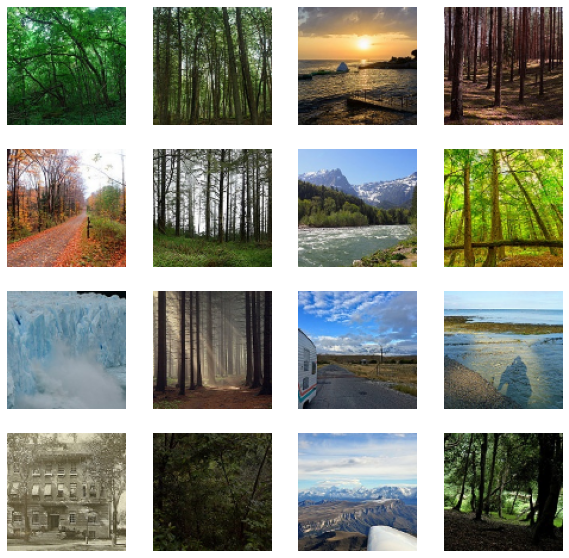

In [ ]:
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')

In [ ]:
X_pred_array = np.array(X_pred)
print(f'X_pred shape  is {X_pred_array.shape}')

X_pred shape  is (7325, 100, 100, 3)


### 8.1.3 Extração de features com VGG16

In [ ]:
preprocessed_images = keras.applications.vgg16.preprocess_input(X_pred_array)
features = conv_base.predict(preprocessed_images)

In [ ]:
features.shape

(7325, 3, 3, 512)

### 8.1.4 Efetuar Prediction

Escolhemos usar o modelo com melhor resultado de accuracy (Secção 7.1.1)

In [ ]:
y_result = model.predict(features)

print('Prediction Shape is {}'.format(y_result.shape))

Prediction Shape is (7325, 6)


Exemplo do array resultado da prediction. Probabilidade por categoria.

In [ ]:
y_result[0]

array([9.9984086e-01, 3.4628320e-07, 2.0470537e-05, 3.6928333e-07,
       1.3104560e-06, 1.3663701e-04], dtype=float32)

### 8.1.5 Análise das predictions

In [ ]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x   

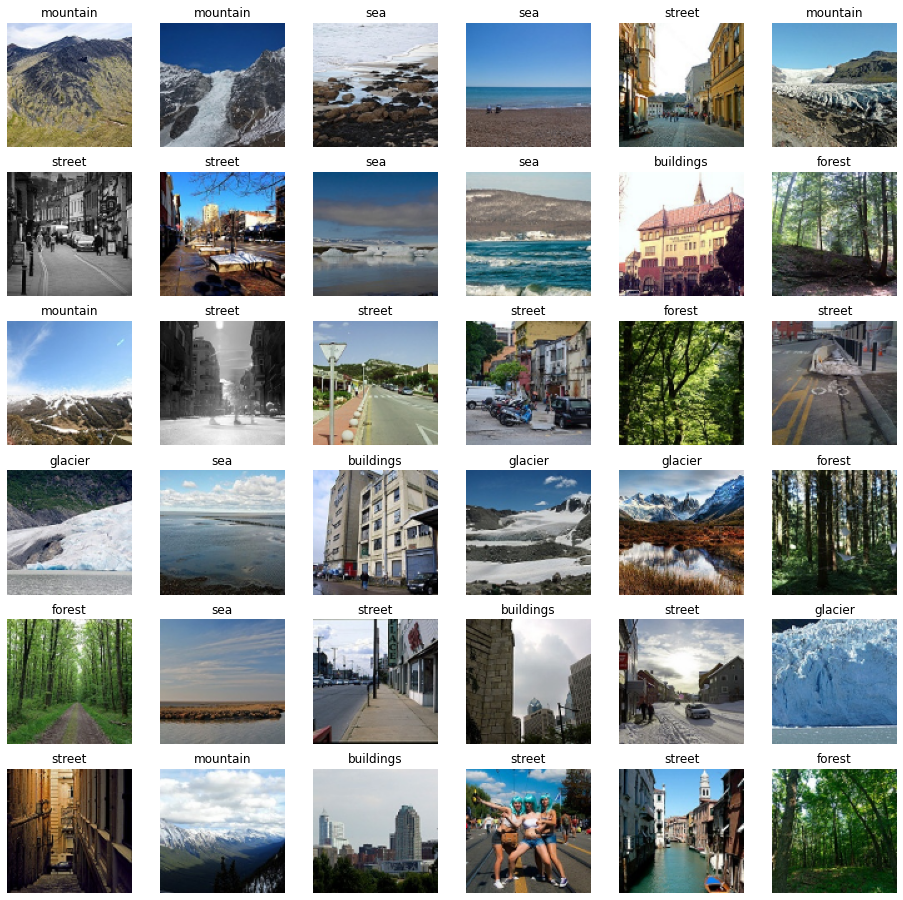

In [ ]:
plt.figure(figsize=(16,16))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))

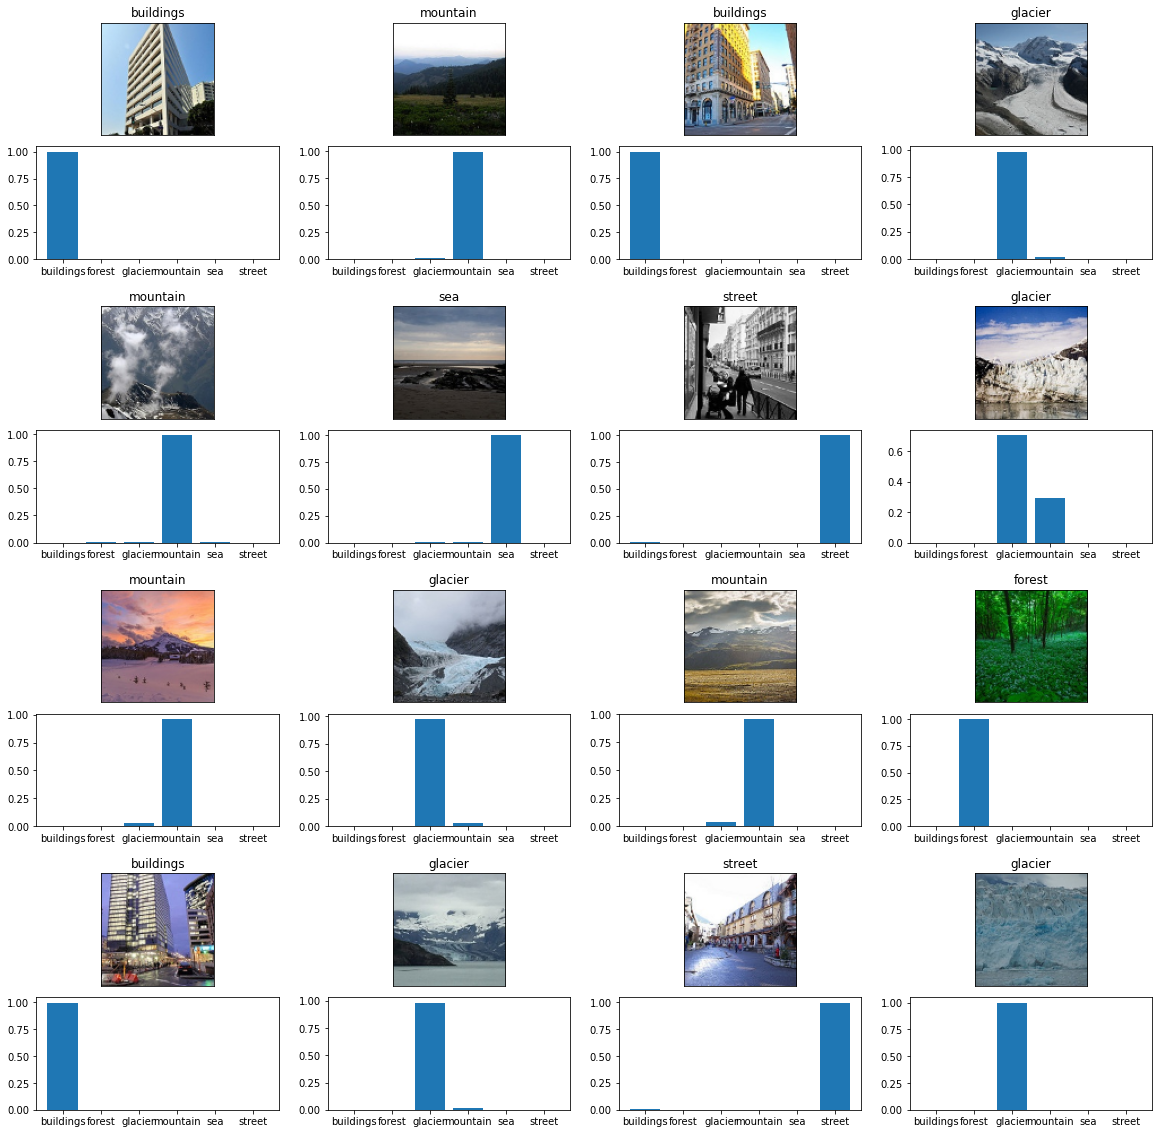

In [ ]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(4, 4, wspace=0.2, hspace=0.2)

for i in range(16):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(X_pred))
    pred_image = np.array([X_pred[rnd_number]])
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(getcode(np.argmax(y_result[rnd_number])))
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar(['buildings','forest', 'glacier', 'mountain', 'sea', 'street'],y_result[rnd_number])
            fig.add_subplot(ax)


fig.show()

Podemos observar que o modelo faz corretamente, e com uma probabilidade elevada da classe certa a maior parte das imagens. Onde vemos mais incerteza na probabildade é principalmente nas imagens mountain/glacier, onde por vezes o modelo tem mais dificuldade em distinguir entre os dois.

## 8.2 Predictions usando o MobileNetv2

In [ ]:
import glob as gb

files = gb.glob(pathname= str('/content/drive/MyDrive/Deeplearning/TP2_dataset/seg_pred/' +'seg_pred/*.jpg'))
print(f'Para o dataset de predição, foram encontrados {len(files)} imagens')


Para o dataset de predição, foram encontrados 7325 imagens


In [ ]:


X_pred = []
i=0
for file in tqdm(files): 
    i+=1
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = cv2.resize(image , (100,100))
    X_pred.append(list(image_array))     
    if(i>200):
      break  

  3%|▎         | 200/7325 [00:00<00:34, 203.77it/s]


### 8.2.1 Amostra do dataset de predictions

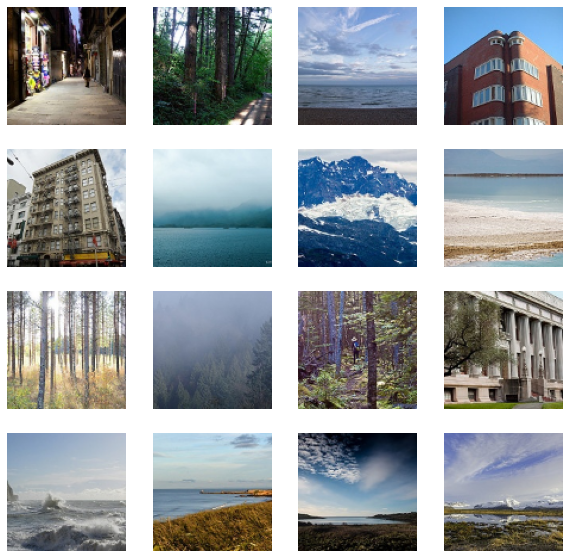

In [ ]:
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')

In [ ]:
X_pred_array = np.array(X_pred)
print(f'X_pred shape  is {X_pred_array.shape}')

X_pred shape  is (201, 100, 100, 3)


### 8.2.2 Extração de features com MobileNetV2 



In [ ]:
preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(X_pred_array)
features = conv_base.predict(preprocessed_images)

In [ ]:
features.shape

(201, 4, 4, 1280)

### 8.2.3 Efetuar Prediction

Escolhemos usar o modelo com melhor resultado de accuracy (Secção 7.1.1)

In [ ]:
y_result = model.predict(features)

print('Shape da predição: {}'.format(y_result.shape))

Shape da predição: (201, 6)


Exemplo do array resultado da prediction. Probabilidade por categoria.

In [ ]:
y_result[0]

array([9.9999690e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.0438482e-06, 9.9032622e-12], dtype=float32)

### 8.2.4 Análise das predictions

In [ ]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x   

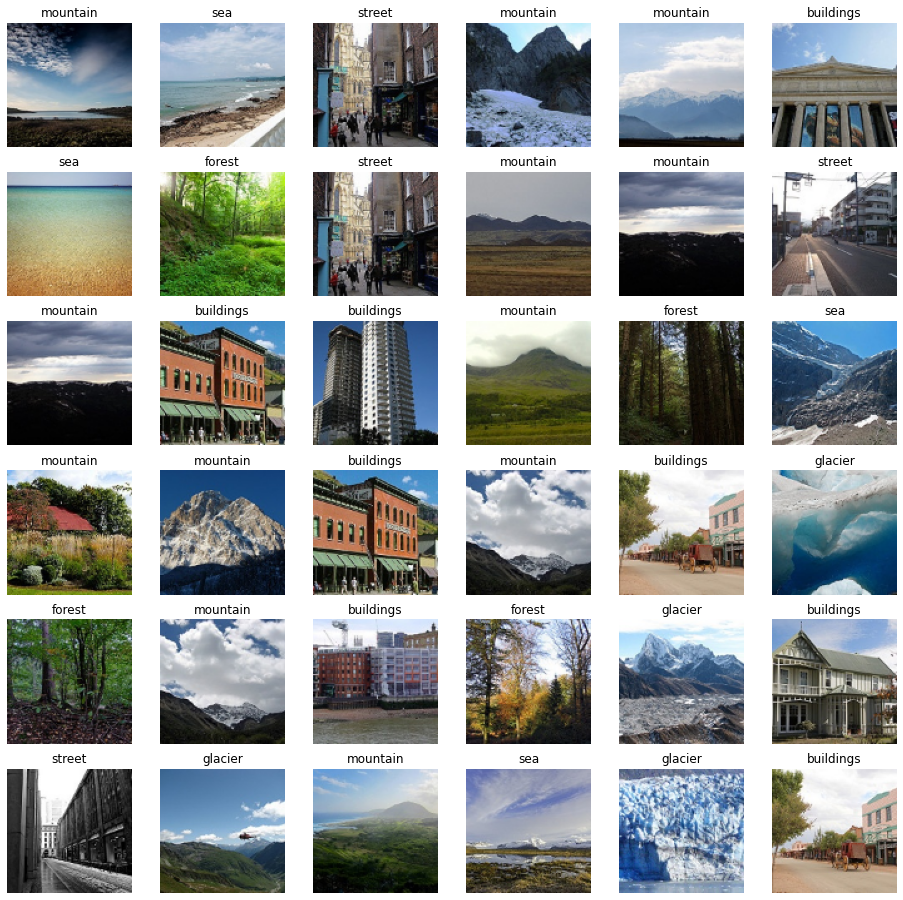

In [ ]:
plt.figure(figsize=(16,16))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_result[i])))

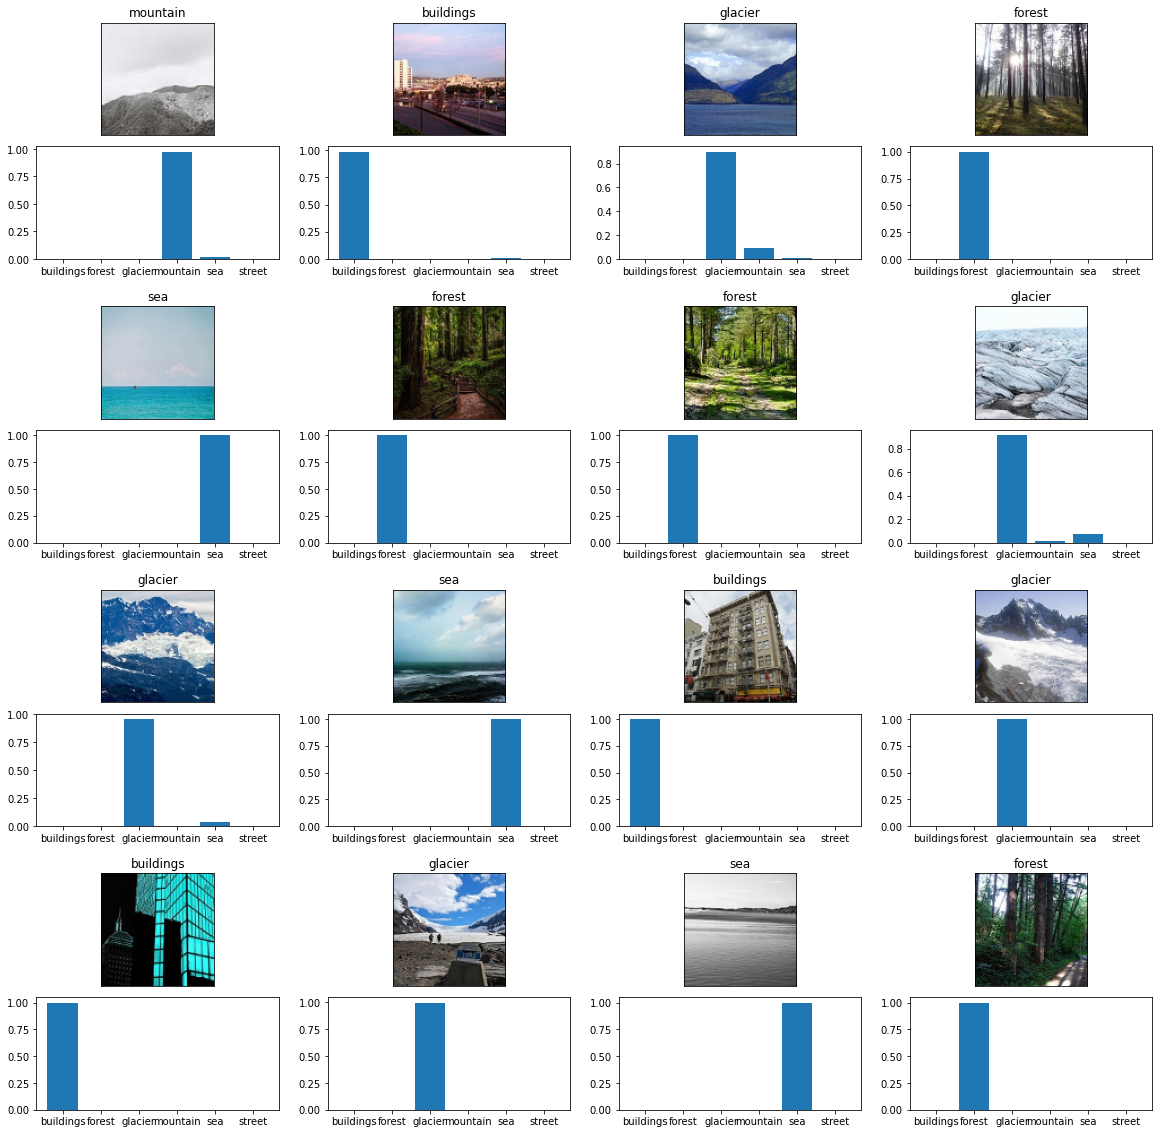

In [ ]:
import matplotlib.gridspec as gridspec
from random import randint

fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(4, 4, wspace=0.2, hspace=0.2)

for i in range(16):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(X_pred_array))
    pred_image = np.array([X_pred[rnd_number]])
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(getcode(np.argmax(y_result[rnd_number])))
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar(['buildings','forest', 'glacier', 'mountain', 'sea', 'street'],y_result[rnd_number])
            fig.add_subplot(ax)


fig.show()

Podemos observar que o modelo faz corretamente, e com uma probabilidade elevada da classe certa a maior parte das imagens. Onde vemos mais incerteza na probabildade é principalmente nas imagens mountain/glacier, onde por vezes o modelo tem mais dificuldade em distinguir entre os dois.

# 9. Mapas de Ativação - Grad-CAM

Para mostrar as áreas relevantes que o modelo usou para obter a sua classificação iremos usar o grad-CAM.
Para este exemplo apenas foi usada uma imagem.

## 9.1 Usando a rede MobileNetv2

In [ ]:
conv_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(100, 100, 3))
conv_base.trainable=False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][

### 9.1.1 Extração de Features da rede pré-treinada

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
#test_features, test_labels =  get_features_and_labels(test_dataset)

  0%|          | 0/342 [00:00<?, ?it/s]

In [ ]:
train_features.shape

(10923, 4, 4, 1280)

### 9.1.2 Adição da rede de classificação

In [ ]:
inputs = keras.Input(shape=(4, 4, 1280)) #alterar shape
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels))

Epoch 1/50
342/342 [==============================] - 3s 7ms/step - loss: 0.6785 - accuracy: 0.7674 - val_loss: 0.3839 - val_accuracy: 0.8777
Epoch 2/50
342/342 [==============================] - 2s 6ms/step - loss: 0.4456 - accuracy: 0.8362 - val_loss: 0.4214 - val_accuracy: 0.8604
Epoch 3/50
342/342 [==============================] - 2s 6ms/step - loss: 0.3915 - accuracy: 0.8558 - val_loss: 0.3855 - val_accuracy: 0.8897
Epoch 4/50
342/342 [==============================] - 2s 6ms/step - loss: 0.3397 - accuracy: 0.8693 - val_loss: 0.4665 - val_accuracy: 0.8879
Epoch 5/50
342/342 [==============================] - 2s 6ms/step - loss: 0.3081 - accuracy: 0.8792 - val_loss: 0.3423 - val_accuracy: 0.8952
Epoch 6/50
342/342 [==============================] - 2s 7ms/step - loss: 0.2651 - accuracy: 0.8964 - val_loss: 0.3973 - val_accuracy: 0.8894
Epoch 7/50
342/342 [==============================] - 2s 6ms/step - loss: 0.2639 - accuracy: 0.8976 - val_loss: 0.3826 - val_accuracy: 0.8945
Epoch 

In [ ]:
img_size = (100, 100)

In [ ]:
last_conv_layer_name = "Conv_1"

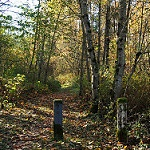

In [ ]:
image_path="/content/drive/MyDrive/Deeplearning/TP2_dataset/seg_pred/seg_pred_low/22.jpg"
display(Image(image_path, width = 300, height = 300))

## 9.2 Pré processamento da imagem

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

## 9.3 Usar modelo 

In [ ]:
preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(get_img_array(image_path, size=img_size))
print('Shape da imagem preprocessed: ', preprocessed_images.shape)
img_array = conv_base.predict(preprocessed_images)
print('Shape da imagem preparada: ', img_array.shape)

# Remove a última camada do modelo (softmax)
model.layers[-1].activation = None

#Imprime a predição
preds = model.predict(img_array)
print("Shape da variável preds: ", preds.shape)
print("Predição:", getlabel(preds[0]))

Shape da imagem preprocessed:  (1, 100, 100, 3)
Shape da imagem preparada:  (1, 4, 4, 1280)
Shape da variável preds:  (1, 6)
Predição: [ -69.860466   31.920885 -100.37702   -62.28362   -55.918636  -68.89426 ]


## 9.4 Criar modelo para usar o grad cam

In [ ]:
#cria um novo modelo para o grad-cam, com a mesma entrada, mas com duas saídas: uma os mapas de ativação
#do modelo e a outra a saída dos logits
grad_model = tf.keras.models.Model(
        [conv_base.inputs], [conv_base.get_layer(last_conv_layer_name).output, conv_base.output])

pred_index=None

with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(preprocessed_images)
        preds=preds[0][0]
        print(preds.shape)
      
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        
        class_channel = preds[:,pred_index]
        print("Shape da variável class_channel: ", class_channel.numpy().shape)
        print("Valor da variável class_channel: ", class_channel.numpy())

grads = tape.gradient(class_channel, last_conv_layer_output)

(4, 1280)
Shape da variável class_channel:  (4,)
Valor da variável class_channel:  [4.829453  6.        6.        3.2198172]


In [ ]:
# Aplica o global average pooling calculando uma média dos gradientes de cada um dos mapas de ativação
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
print("shape da variável pooled_grads", pooled_grads.numpy().shape)

shape da variável pooled_grads (1280,)


Passo 3 e 4: Atribui o resultado do global average pooling como um "peso" para cada um dos mapas de aivação, multiplicando os valores das ativações por esses pesos. Soma todos os mapas de ativação, reduzindo-os a um único mapa.

In [ ]:
print("Shape da variável last_conv_layer_output", last_conv_layer_output.numpy().shape)
last_conv_layer_output = last_conv_layer_output[0]
print("Shape da variável last_conv_layer_output", last_conv_layer_output.numpy().shape)

heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
print("Shape da variável heatmap", heatmap.numpy().shape)

heatmap = tf.squeeze(heatmap)
print("Shape da variável heatmap", heatmap.numpy().shape)
print("Valor da variável heatmap", heatmap.numpy())





Shape da variável last_conv_layer_output (1, 4, 4, 1280)
Shape da variável last_conv_layer_output (4, 4, 1280)
Shape da variável heatmap (4, 4, 1)
Shape da variável heatmap (4, 4)
Valor da variável heatmap [[1.1539589  1.5136001  1.5291033  0.95275444]
 [1.4420785  1.4421355  1.343527   0.7894949 ]
 [1.1024467  0.9500574  0.20269199 0.44232488]
 [0.8402307  0.64694583 0.21302895 0.21187198]]


In [ ]:
#aplica a função ReLU deixando somente os pixels que contribuíram positivamente para a classificação
heatmap = tf.maximum(heatmap, 0)
print("Valor da variável heatmap", heatmap.numpy())

Valor da variável heatmap [[1.1539589  1.5136001  1.5291033  0.95275444]
 [1.4420785  1.4421355  1.343527   0.7894949 ]
 [1.1024467  0.9500574  0.20269199 0.44232488]
 [0.8402307  0.64694583 0.21302895 0.21187198]]


Visualização do Heatmap

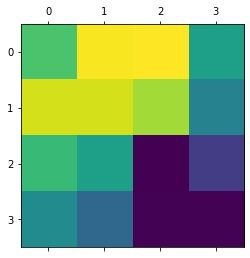

In [ ]:
#normaliza o heatmap entre 0 e 1
heatmap = heatmap/tf.math.reduce_max(heatmap)

#transforma o tensor em array numpy
heatmap = heatmap.numpy()

#imprime como imagem
plt.matshow(heatmap)
plt.show()



Método para transformar o mapa de calor gerado no tamanho da imagem e gerar um mapa de calor sobreposto

## 9.5 Mostrar Resultados

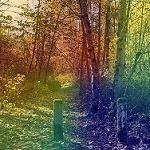

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=300, height=300))


save_and_display_gradcam(image_path, heatmap)
